In [1]:
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from nested.optimize_utils import PopulationAnnealing

In [3]:
param_names = ['x', 'y']
bounds = [(-10., 10.), (-10., 10.)]

feature_names = []
objective_names = ['f1', 'f2']

def evaluate_example_model(parameters, **kwargs):
    x, y = parameters
        
    f1 = 0.125*(20. + x + y)**2.
    f2 = 100. + x*y
    
    features = dict()
    objectives = {'f1': f1, 'f2': f2}
    
    return features, objectives

In [24]:
param_gen = PopulationAnnealing(bounds=bounds, param_names=param_names, feature_names=feature_names, 
                                objective_names=objective_names, pop_size=1, path_length=1, max_iter=20)

RelativeBoundedStep: starting parameters not specified; choosing random initial parameters.


In [25]:
param_gen.x0

array([-6.85087844,  3.43721225])

In [26]:
param_gen_iter = iter(param_gen())

In [27]:
result = next(param_gen_iter)

In [28]:
type(result), type(result[0]), type(result[1])

(tuple, list, list)

In [29]:
population, model_ids = result
print(population, model_ids)

[array([-6.85087844,  3.43721225])] [0]


In [10]:
# next(param_gen_iter)

Exception: PopulationAnnealing: objectives from previous Gen 0 were not stored or evaluated

In [30]:
features, objectives = evaluate_example_model(population[0])
features_list = [features]
objectives_list = [objectives]
param_gen.update_population(features_list, objectives_list)

In [31]:
next(param_gen_iter)

([array([-4.24017746,  6.93956461])], [1])

In [32]:
param_gen = PopulationAnnealing(bounds=bounds, param_names=param_names, feature_names=feature_names, 
                                objective_names=objective_names, pop_size=50, path_length=1, max_iter=20)

RelativeBoundedStep: starting parameters not specified; choosing random initial parameters.


In [33]:
for population, model_ids in param_gen():
    features_list, objectives_list = [], []
    for params in population:
        features, objectives = evaluate_example_model(params)
        features_list.append(features)
        objectives_list.append(objectives)
    param_gen.update_population(features_list, objectives_list)

<IPython.core.display.Javascript object>


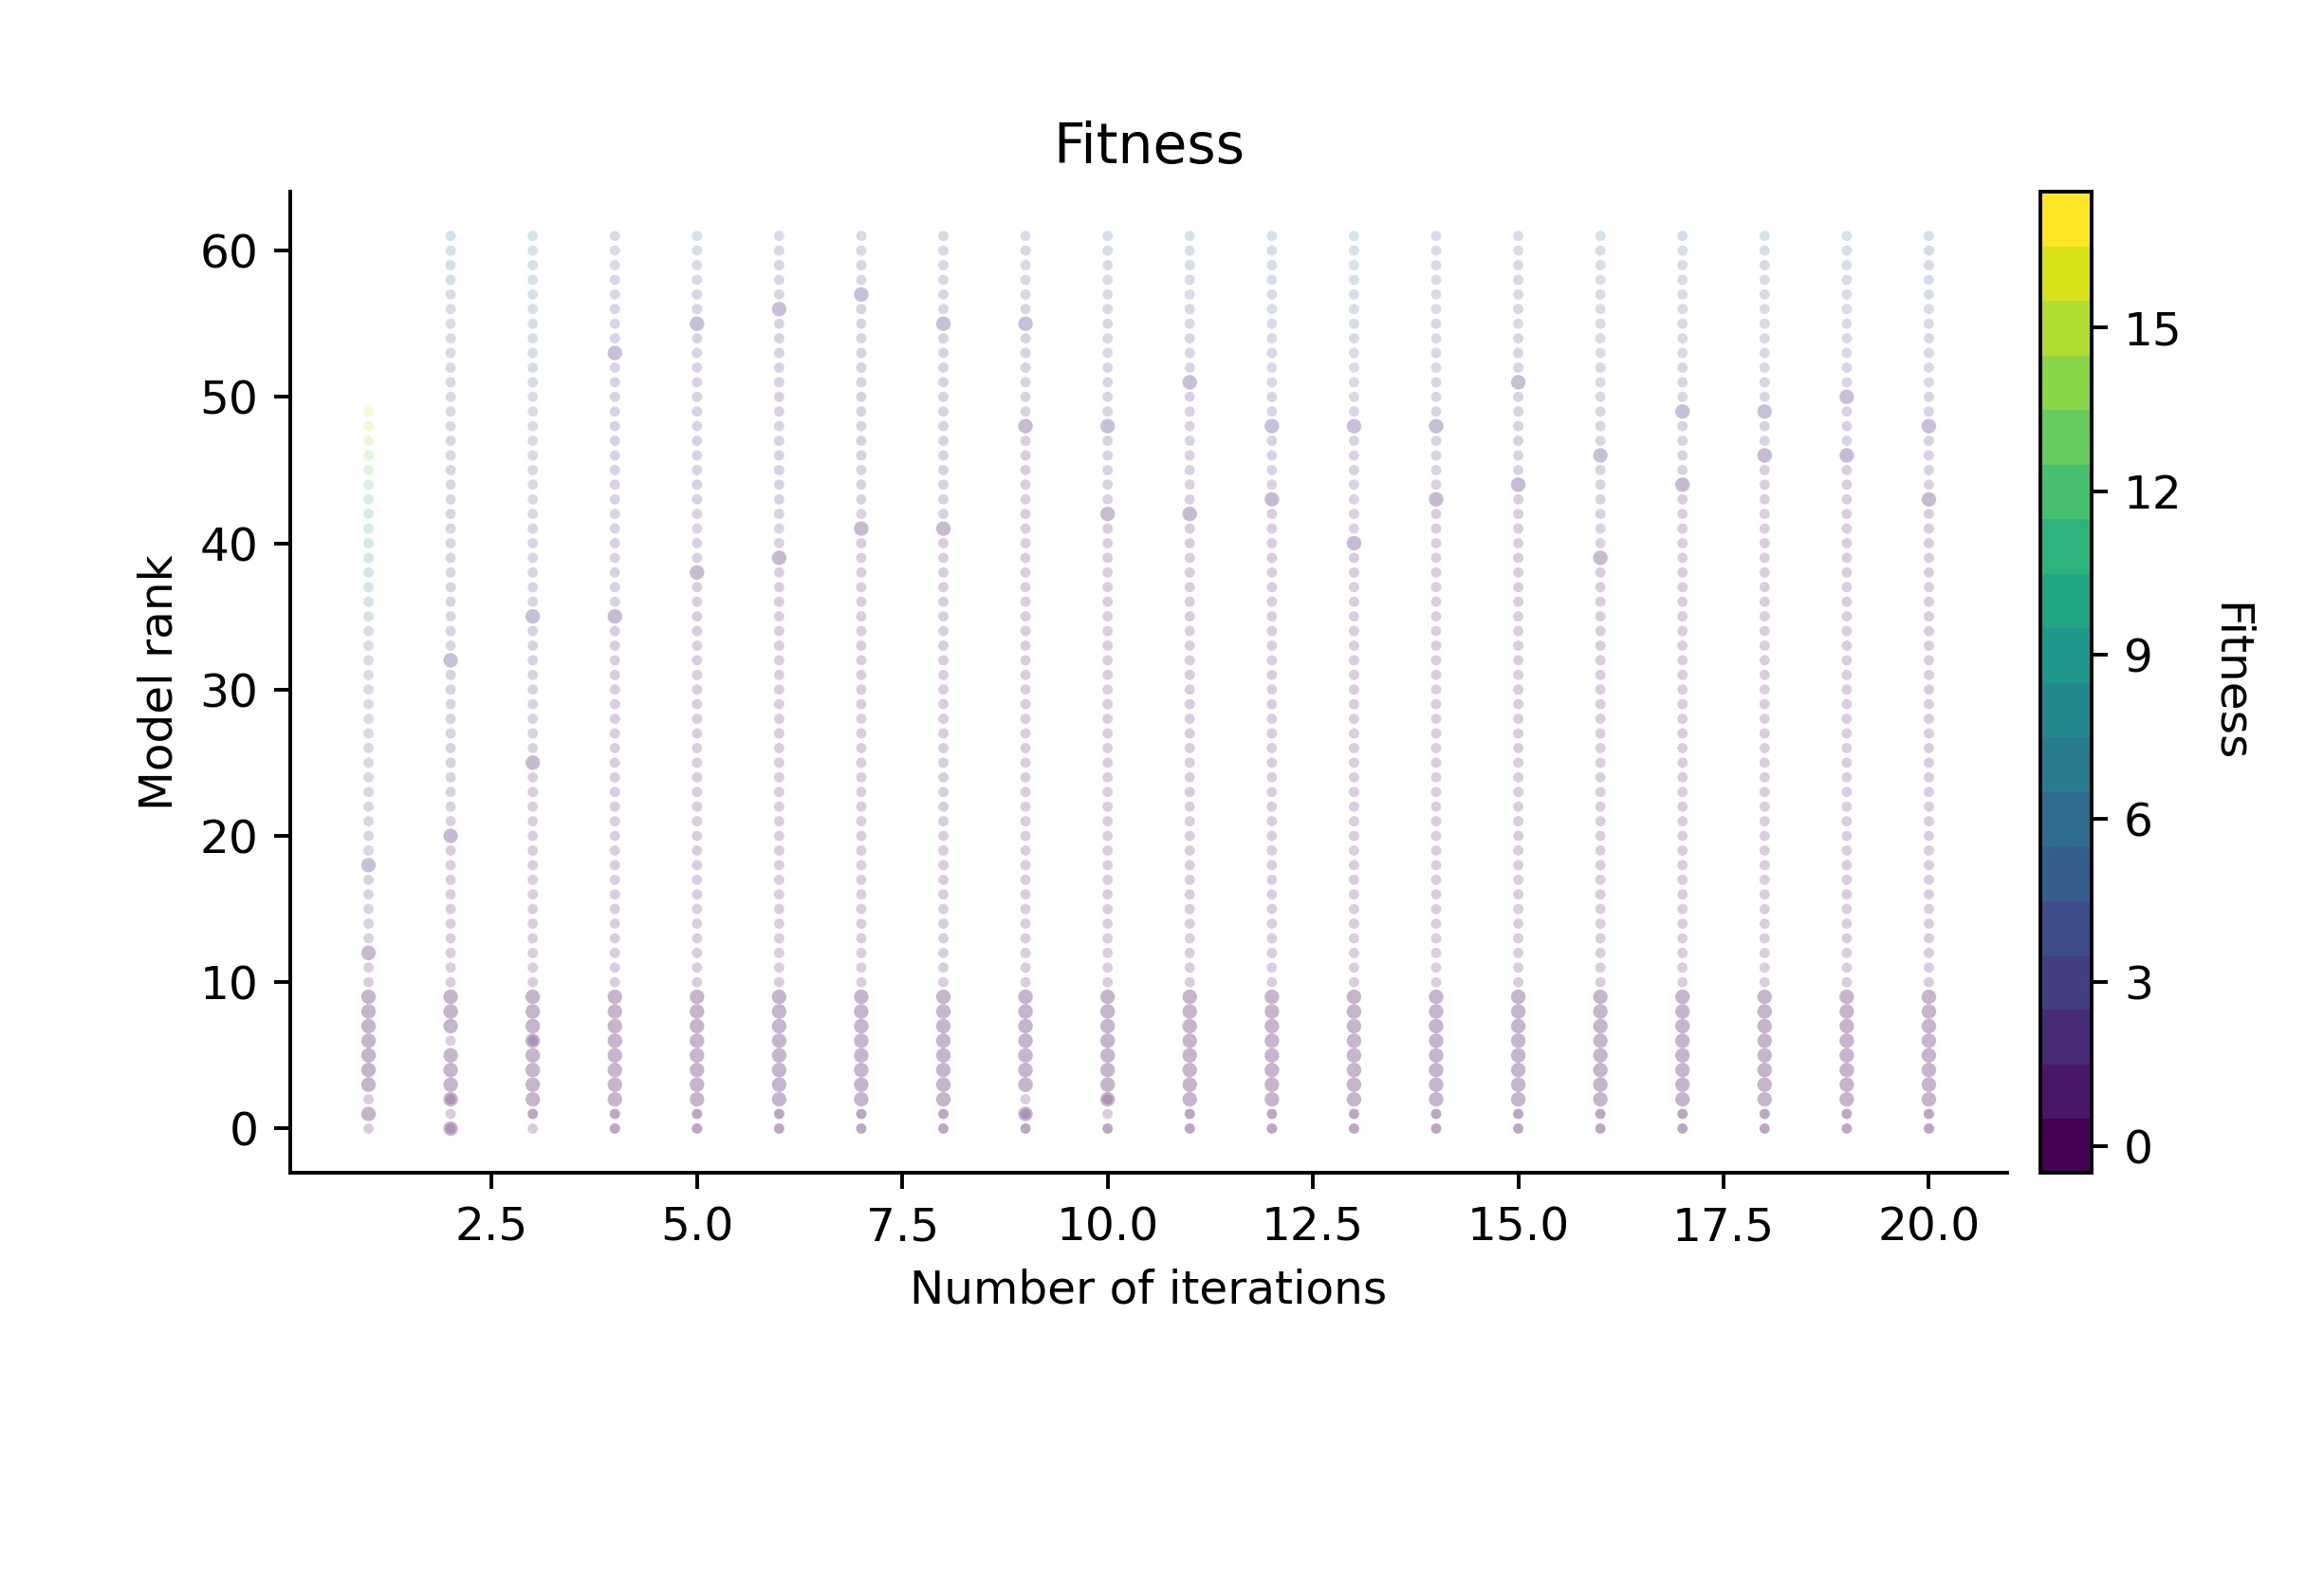

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


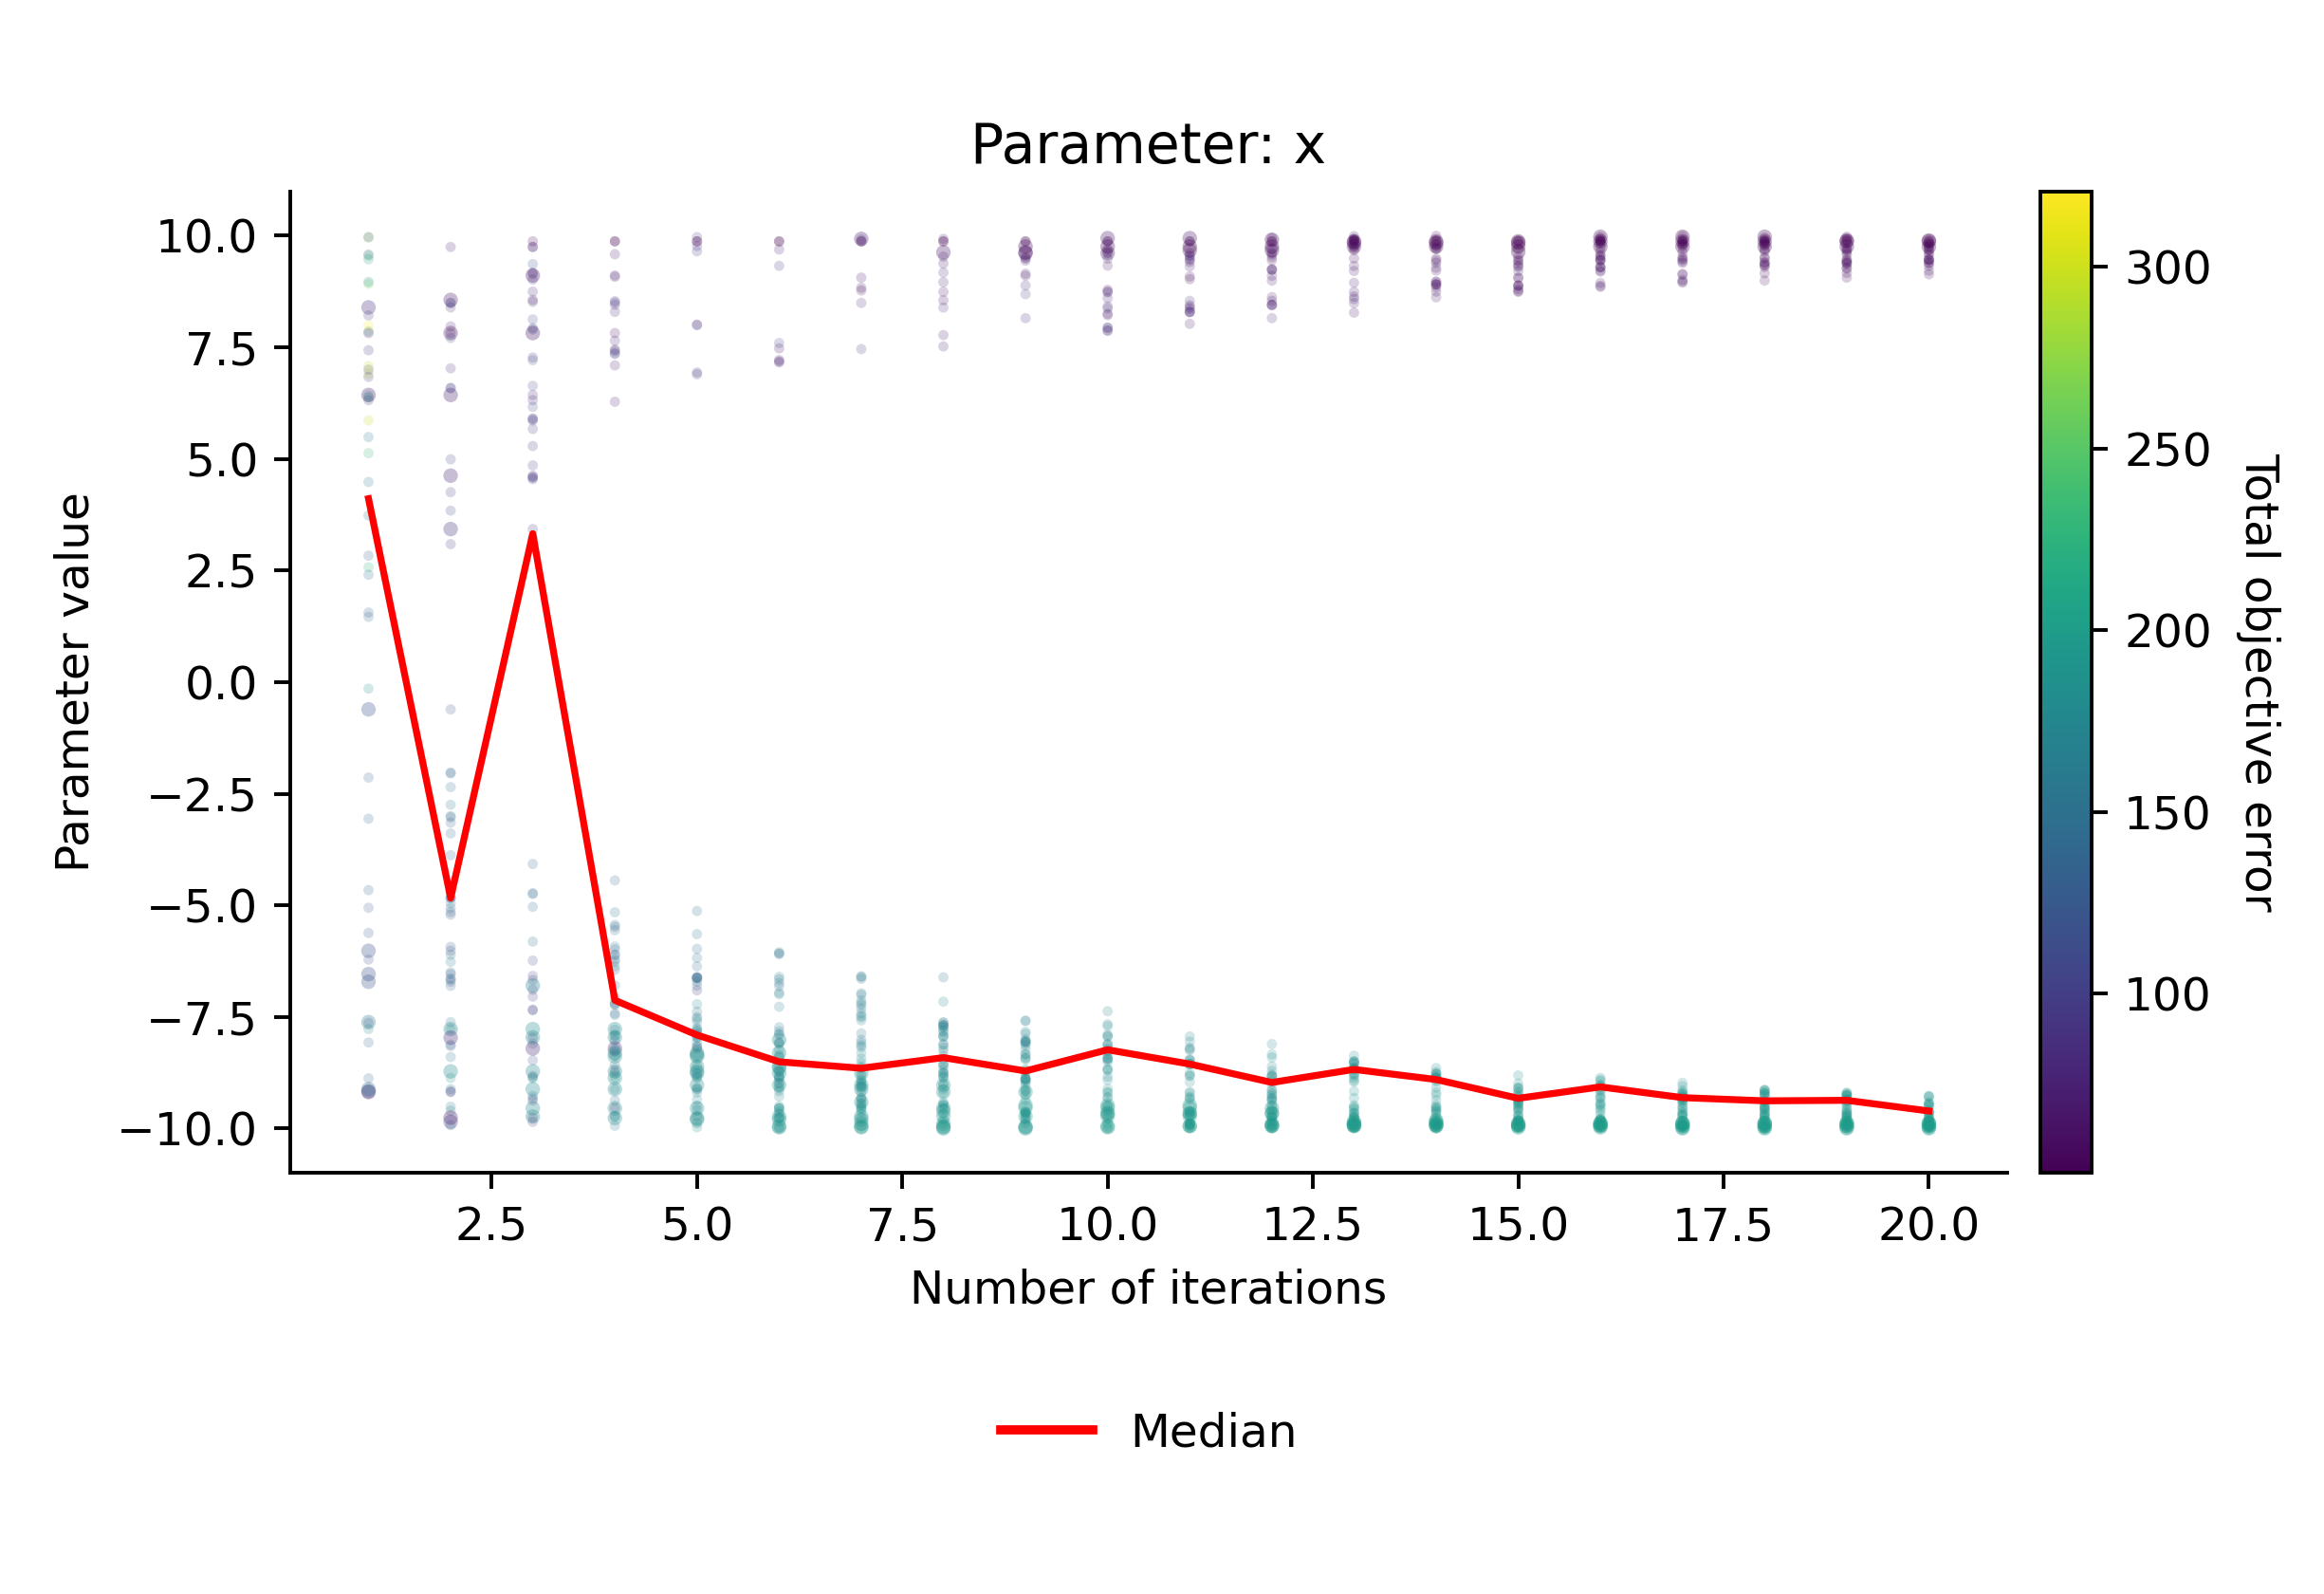

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


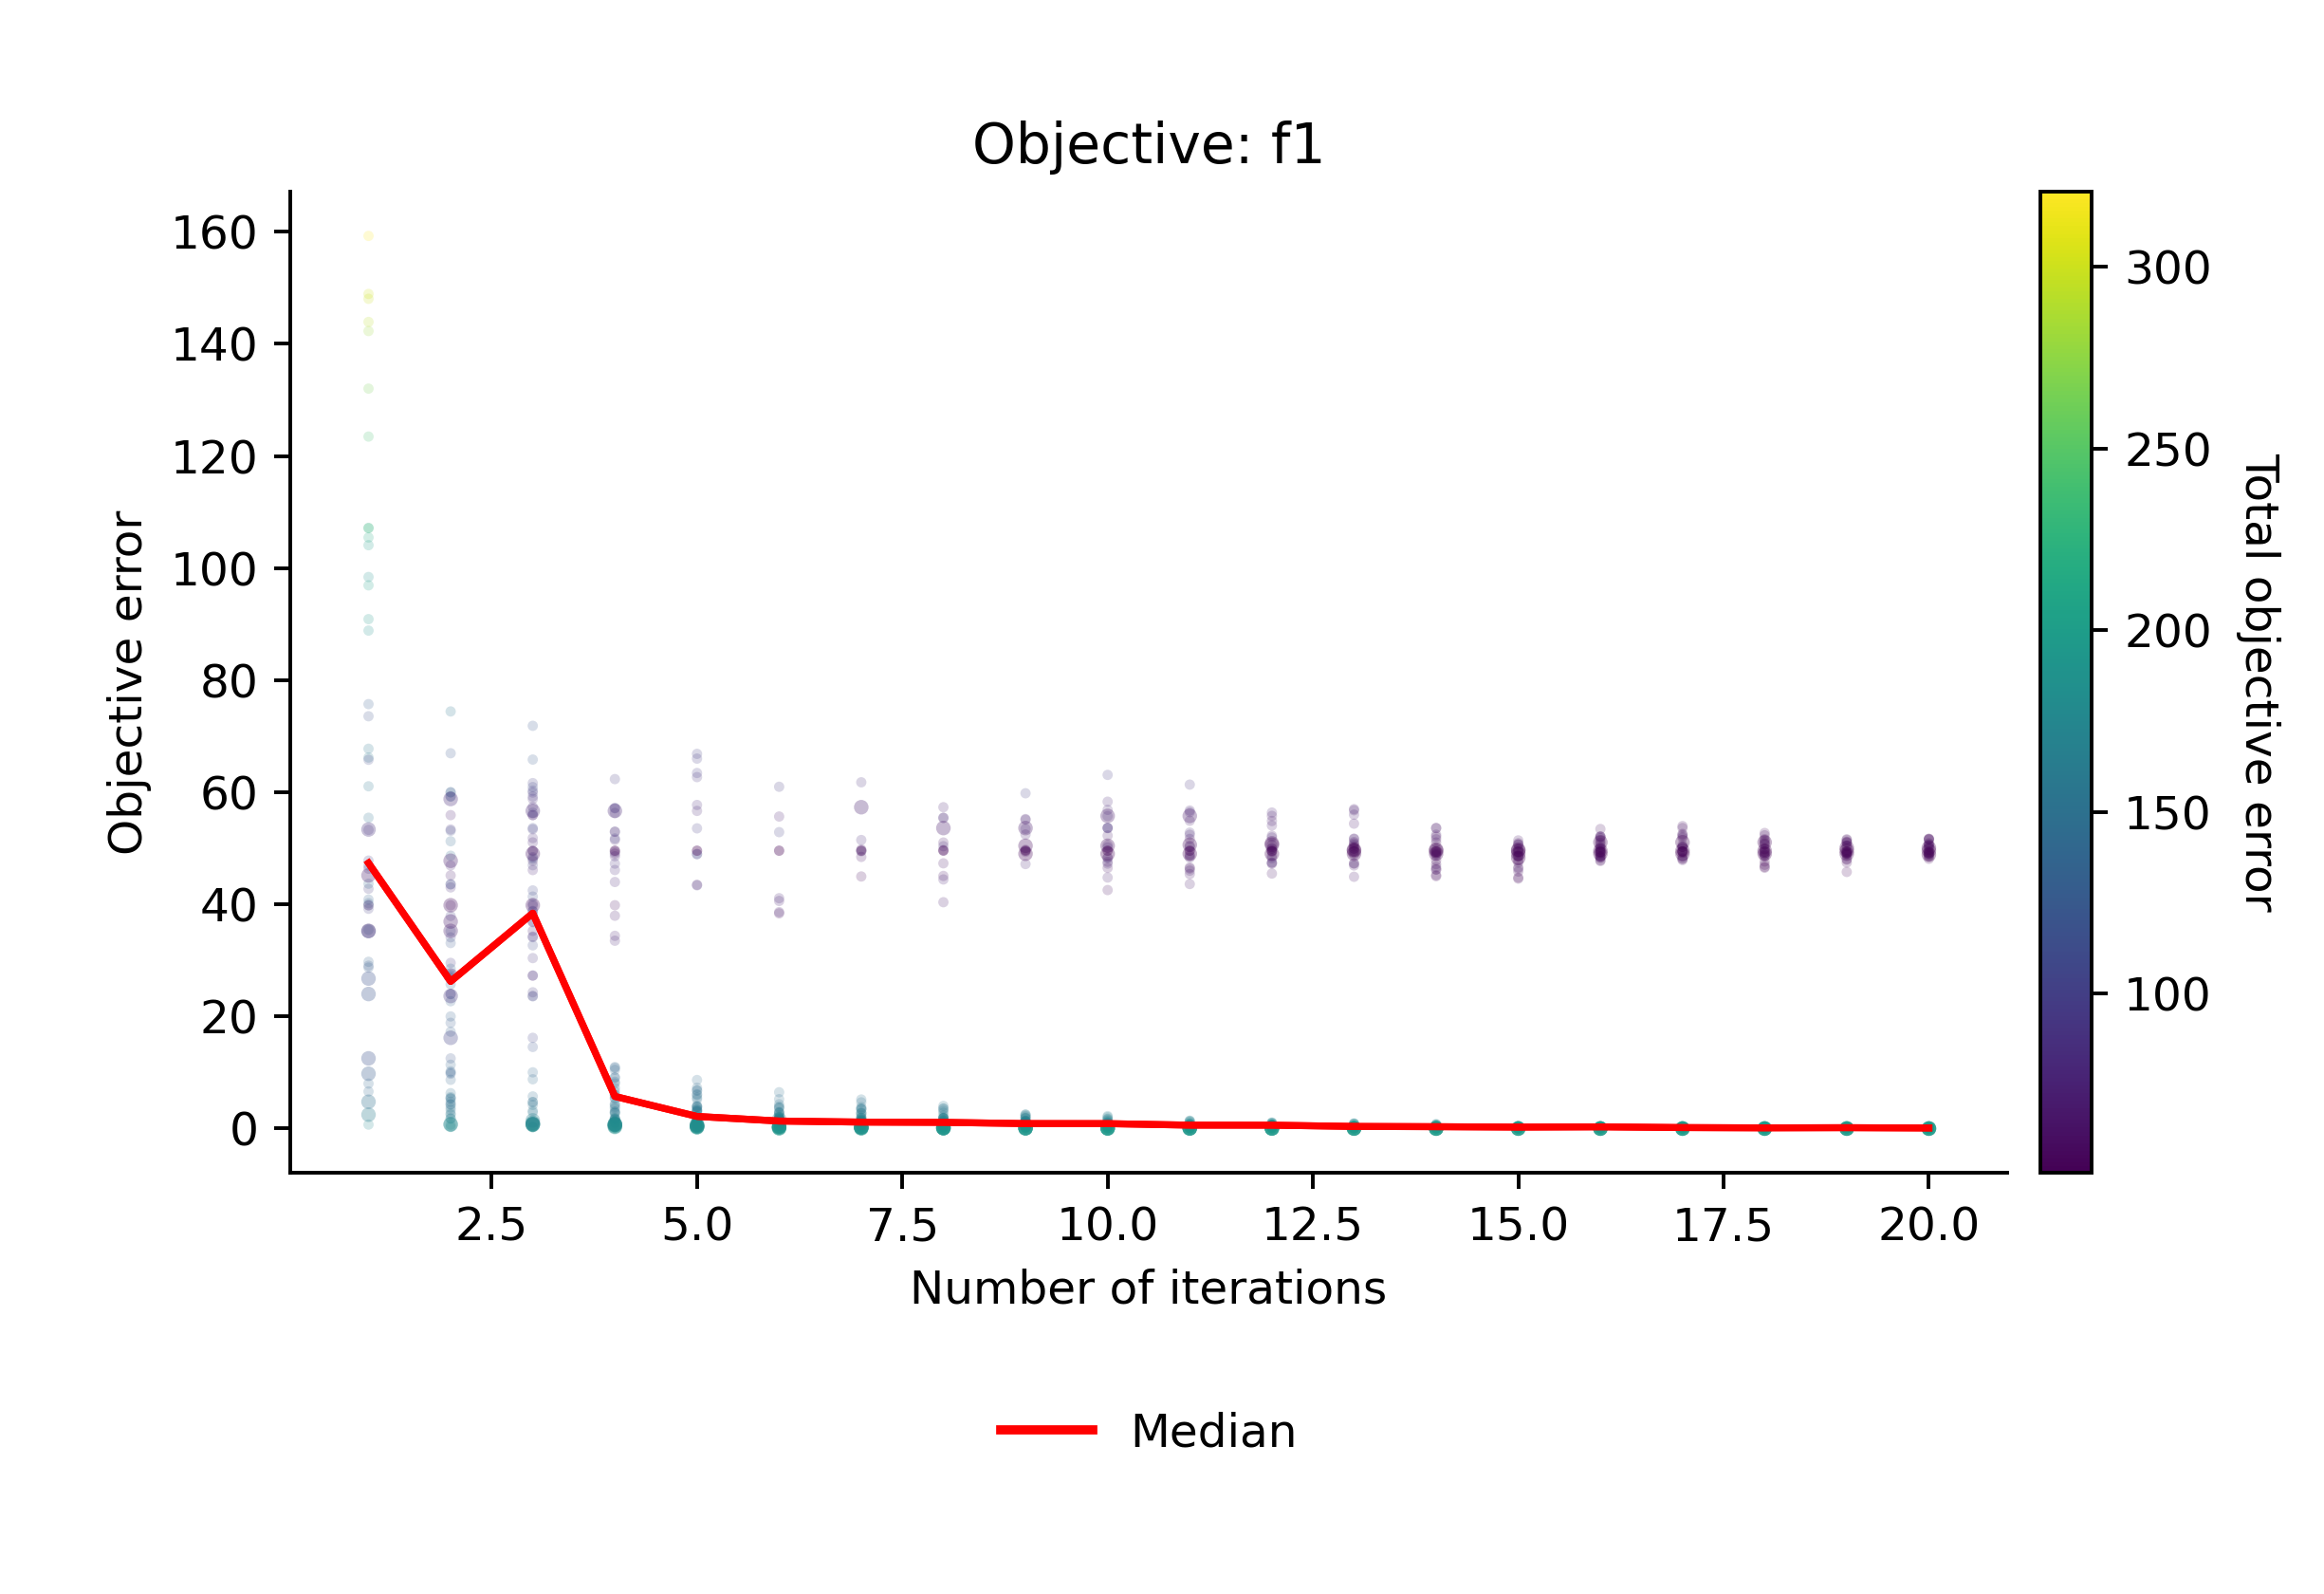

<IPython.core.display.Javascript object>


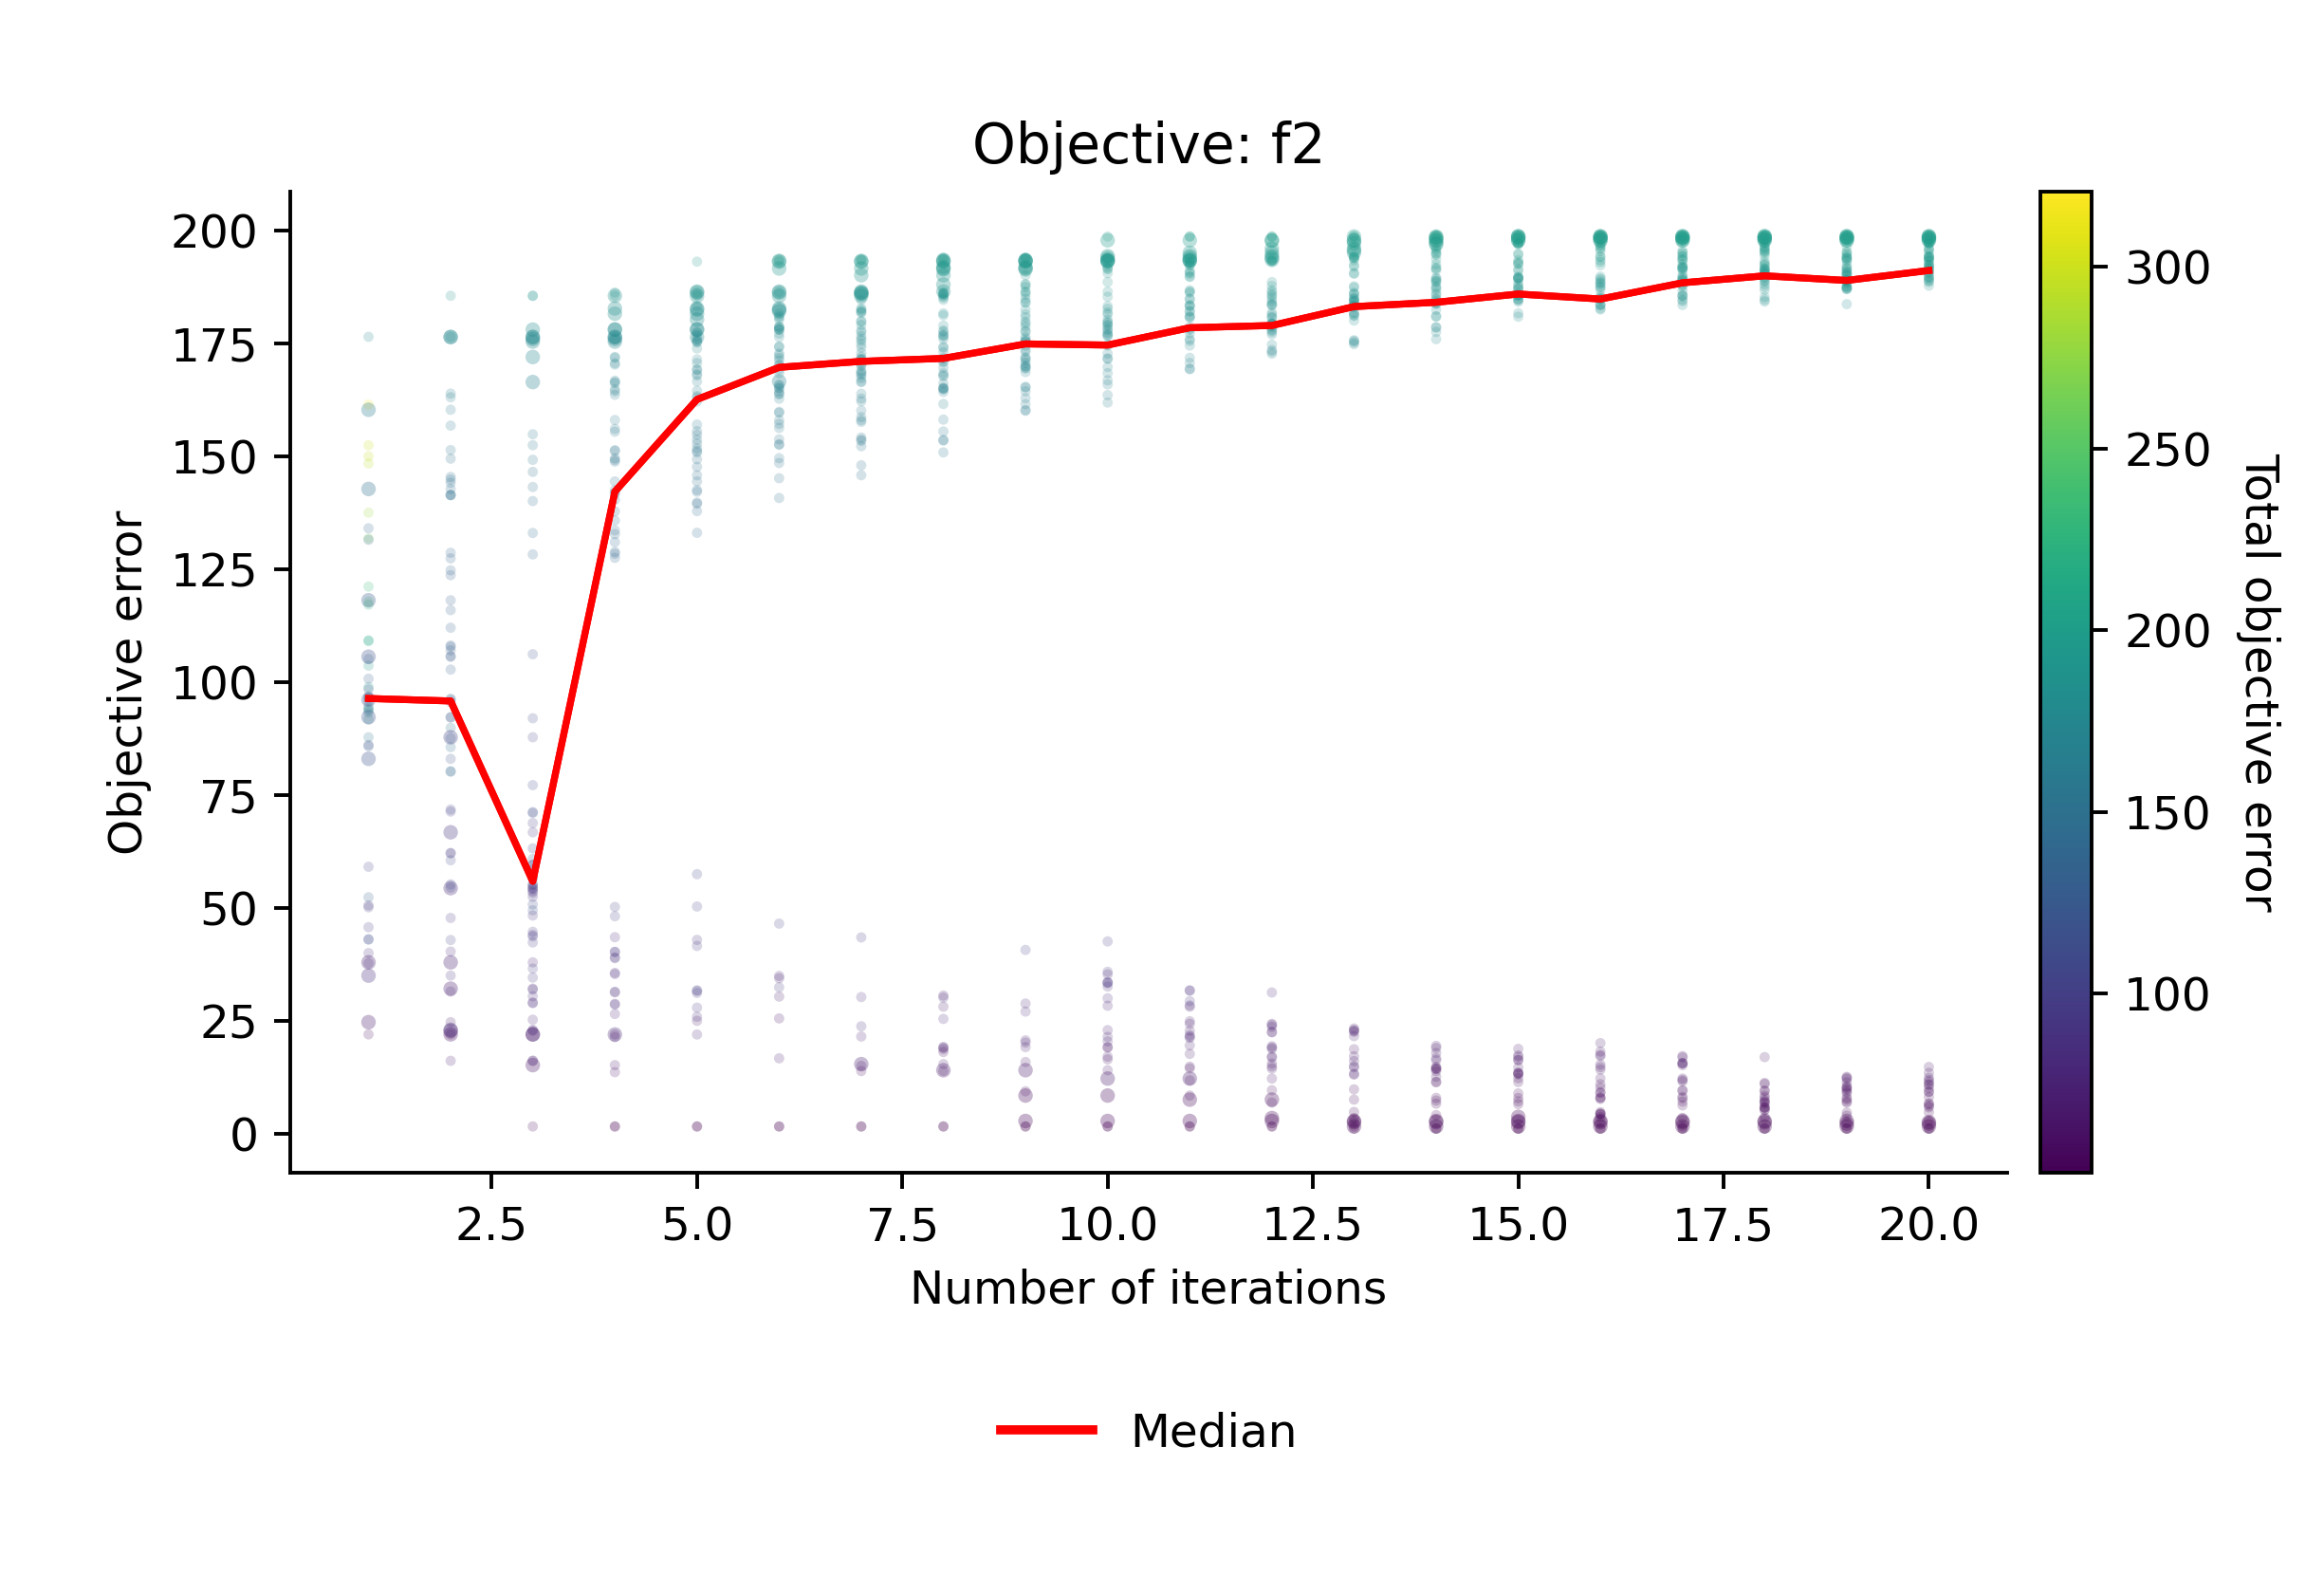

In [34]:
param_gen.storage.plot(['parameters', 'objectives'], energy_scale='linear', energy_color='absolute')

In [35]:
param_gen.storage.survivors[-1][0].__dict__

{'x': array([ 9.87608161, -9.99798884]),
 'features': array([], dtype=float64),
 'objectives': array([49.39232151,  1.25904635]),
 'normalized_objectives': array([0.8985961, 0.       ], dtype=float32),
 'energy': 0.8985961,
 'rank': 0,
 'distance': None,
 'fitness': 0,
 'survivor': True,
 'model_id': 600}

In [25]:
param_gen.storage.specialists[-1][0].__dict__

{'x': array([-9.93986027, -9.98621725]),
 'features': array([], dtype=float64),
 'objectives': array([6.83066605e-04, 1.99261604e+02]),
 'normalized_objectives': array([0., 1.], dtype=float32),
 'energy': 1.0,
 'rank': 1,
 'distance': None,
 'fitness': 0,
 'survivor': True,
 'model_id': 968}

In [79]:
param_gen.storage.specialists[-1][1].__dict__

{'x': array([-9.96989327,  9.9796148 ]),
 'features': array([], dtype=float64),
 'objectives': array([50.04861946,  0.50430553]),
 'normalized_objectives': array([0.90303403, 0.        ], dtype=float32),
 'energy': 0.90303403,
 'rank': 0,
 'distance': None,
 'fitness': 0,
 'survivor': True,
 'model_id': 974}

<IPython.core.display.Javascript object>


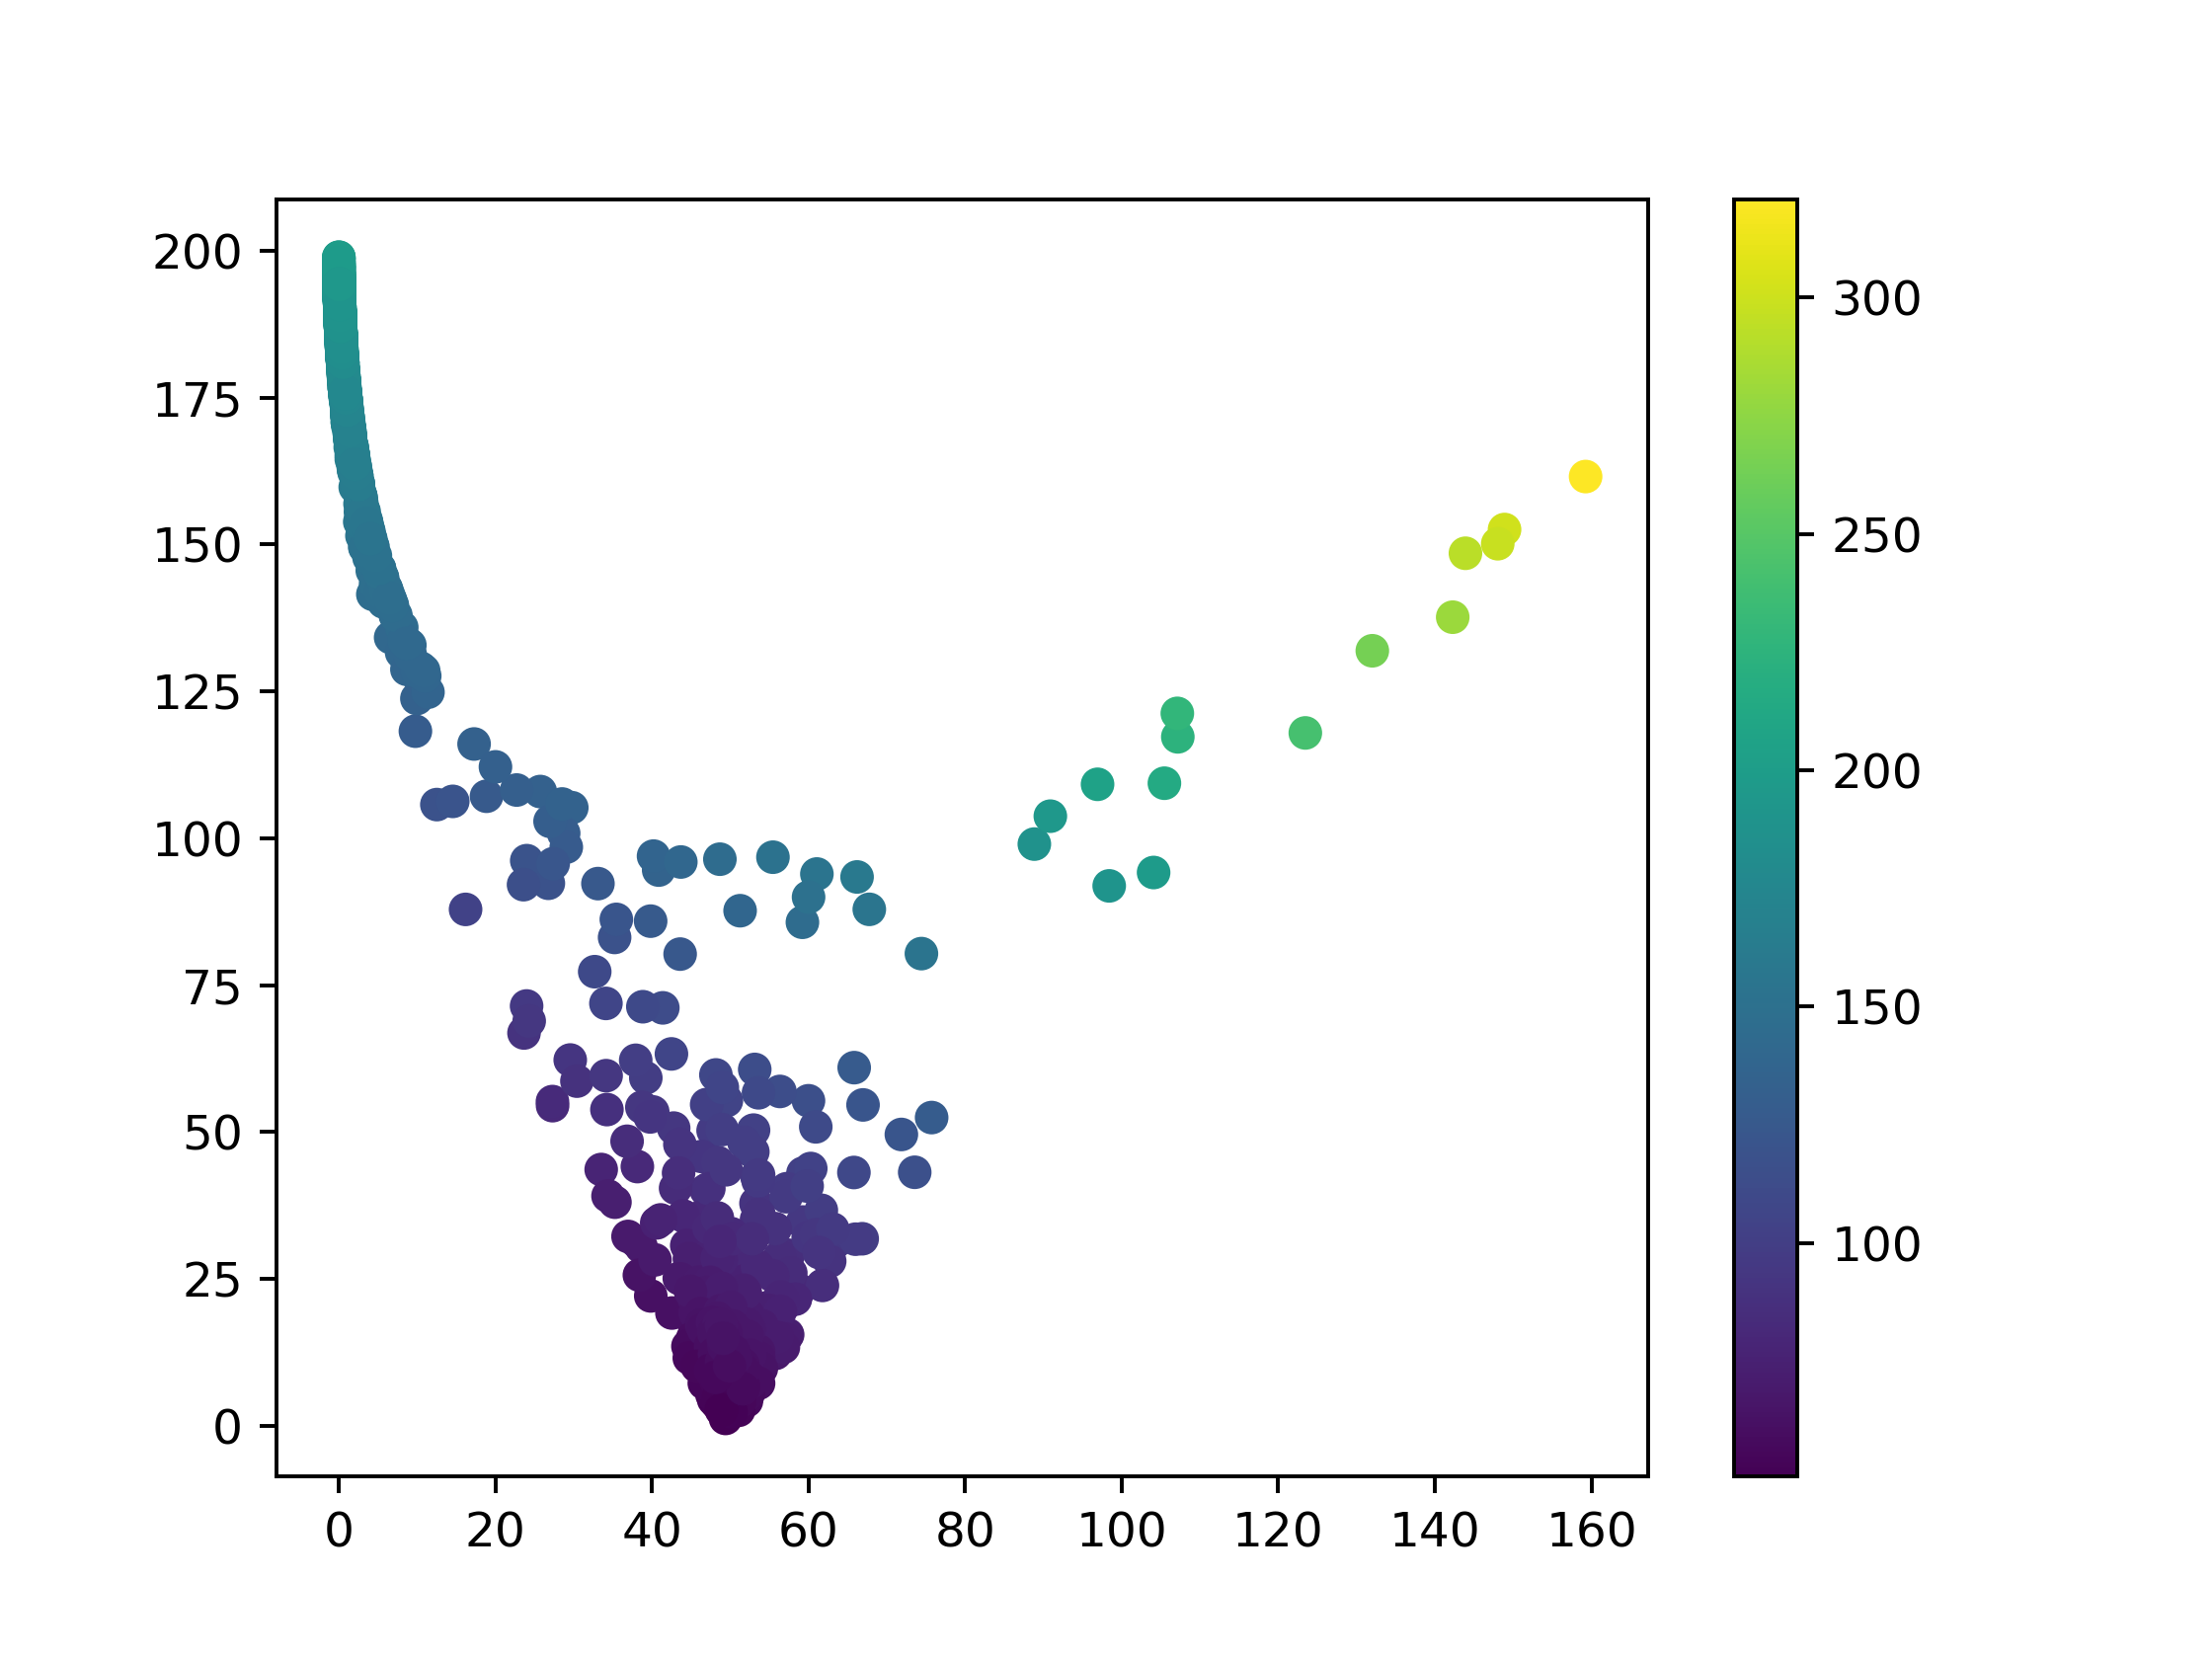

<IPython.core.display.Javascript object>


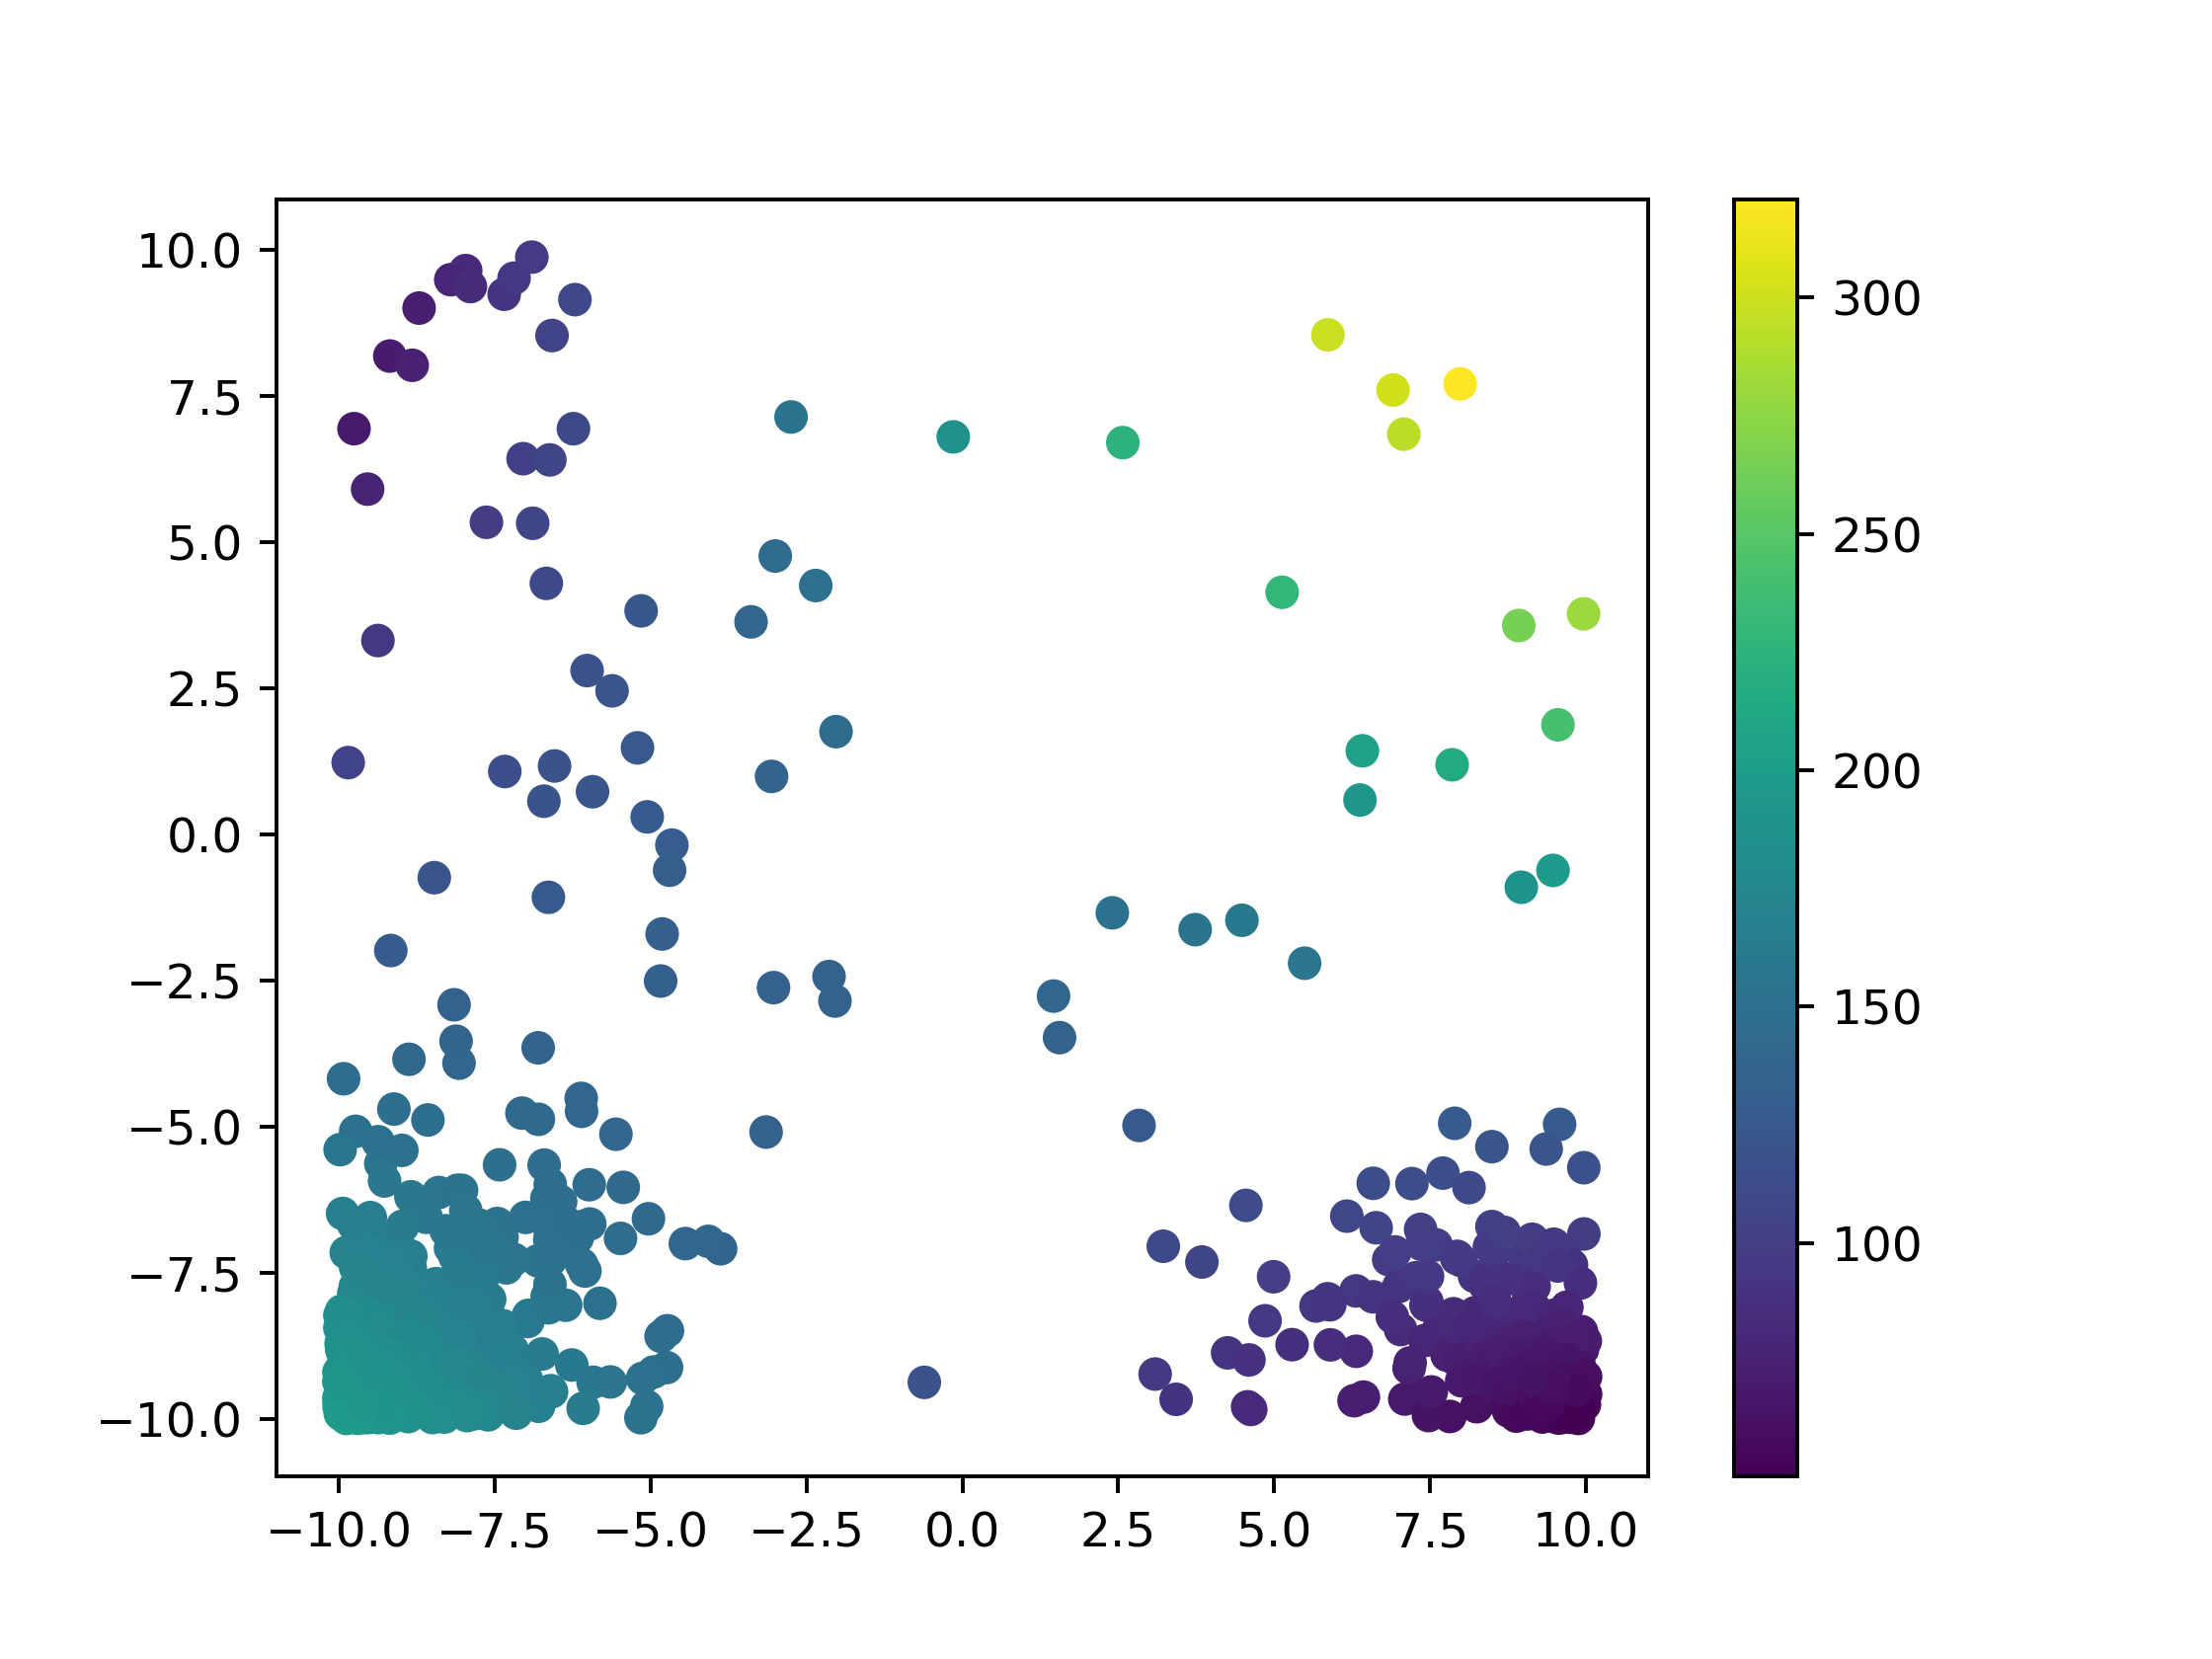

In [36]:
plt.figure()
f1 = [indiv.objectives[0] for gen in param_gen.storage.history for indiv in gen]
f2 = [indiv.objectives[1] for gen in param_gen.storage.history for indiv in gen]
c = [i for i, gen in enumerate(param_gen.storage.history) for indiv in gen]
fitness = [indiv.fitness for gen in param_gen.storage.history for indiv in gen]
abs_energy = [np.sum(indiv.objectives) for gen in param_gen.storage.history for indiv in gen]
energy = [indiv.energy for gen in param_gen.storage.history for indiv in gen]

# plt.scatter(f1, f2, c=c)
plt.scatter(f1, f2, c=abs_energy)
# plt.scatter(f1, f2, c=energy)
plt.colorbar()

plt.figure()
x = [indiv.x[0] for gen in param_gen.storage.history for indiv in gen]
y = [indiv.x[1] for gen in param_gen.storage.history for indiv in gen]
# plt.scatter(x, y, c=c)
plt.scatter(x, y, c=abs_energy)
# plt.scatter(x, y, c=energy)
plt.colorbar()

In [55]:
param_gen.min_objectives, param_gen.max_objectives

(array([0.00034171, 0.20177055]), array([195.65503057, 199.4777017 ]))

In [34]:
population = param_gen.storage.history[-1]
disp = True

def dominates(p, q):
    """
    Individual p dominates Individual q if each of its objective values is equal or better, and at least one of
    its objective values is better.
    :param p: :class:'Individual'
    :param q: :class:'Individual'
    :return: bool
    """
    diff12 = np.subtract(p.objectives, q.objectives)
    return ((diff12 <= 0.).all()) and ((diff12 < 0.).any())

pop_size = len(population)
num_objectives = [len(individual.objectives) for individual in population if individual.objectives is not None]
if len(num_objectives) < pop_size:
    raise Exception('assign_fitness_by_dominance: objectives have not been stored for all Individuals in '
                    'population')
num_objectives = max(num_objectives)
if num_objectives > 1:
    F = {0: []}  # first front of dominant Individuals
    S = dict()
    n = dict()

    for p in range(len(population)):
        S[p] = []  # list of Individuals that p dominates
        n[p] = 0  # number of Individuals that dominate p

        for q in range(len(population)):
            if dominates(population[p], population[q]):
                S[p].append(q)
            elif dominates(population[q], population[p]):
                n[p] += 1

        if n[p] == 0:
            population[p].fitness = 0  # fitness 0 indicates first dominant front
            F[0].append(p)

    # excluding the Individuals that dominated the previous front, find the next front
    i = 0
    while len(F[i]) > 0:
        F[i + 1] = []  # next front
        # take the elements from the previous front
        for p in F[i]:
            # take the elements that p dominates
            for q in S[p]:
                # decrease domination value of all Individuals that p dominates
                n[q] -= 1
                if n[q] == 0:
                    population[q].fitness = i + 1  # assign fitness of current front
                    F[i + 1].append(q)
        i += 1
else:
    for individual in population:
        individual.fitness = 0
if disp:
    print(F)

{0: [1, 4, 5, 7, 8, 9, 12, 15, 18, 19, 21, 22, 23, 26, 29, 33, 35, 36, 37, 40, 43, 44, 46, 47, 49], 1: [32, 14, 41, 24], 2: [6, 20, 45, 17, 30], 3: [34, 3, 0, 38, 16], 4: [2, 31, 42, 13, 39], 5: [10, 25, 27, 28, 48], 6: [11], 7: []}


In [56]:
param_gen.num_diversity_survivors

2

In [57]:
param_gen.storage.global_renormalize_objectives()

<IPython.core.display.Javascript object>


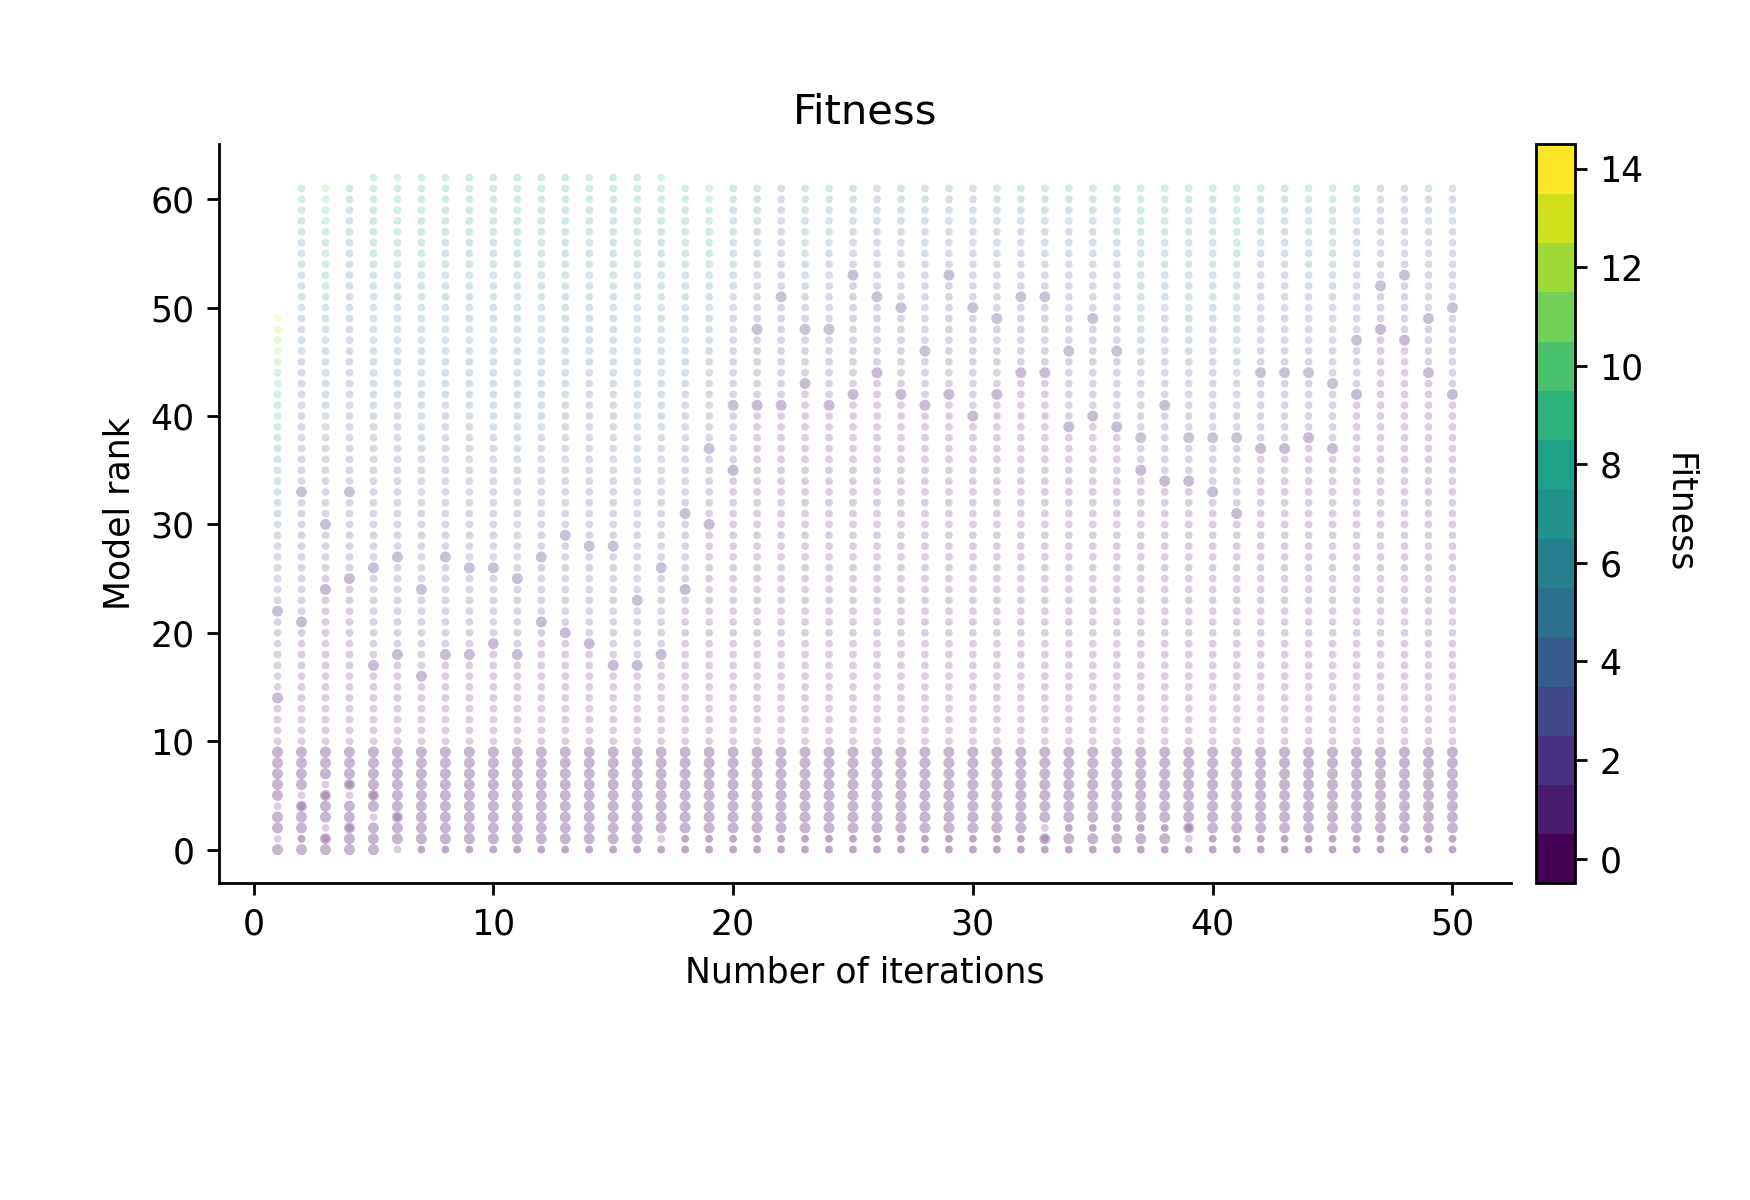

<IPython.core.display.Javascript object>


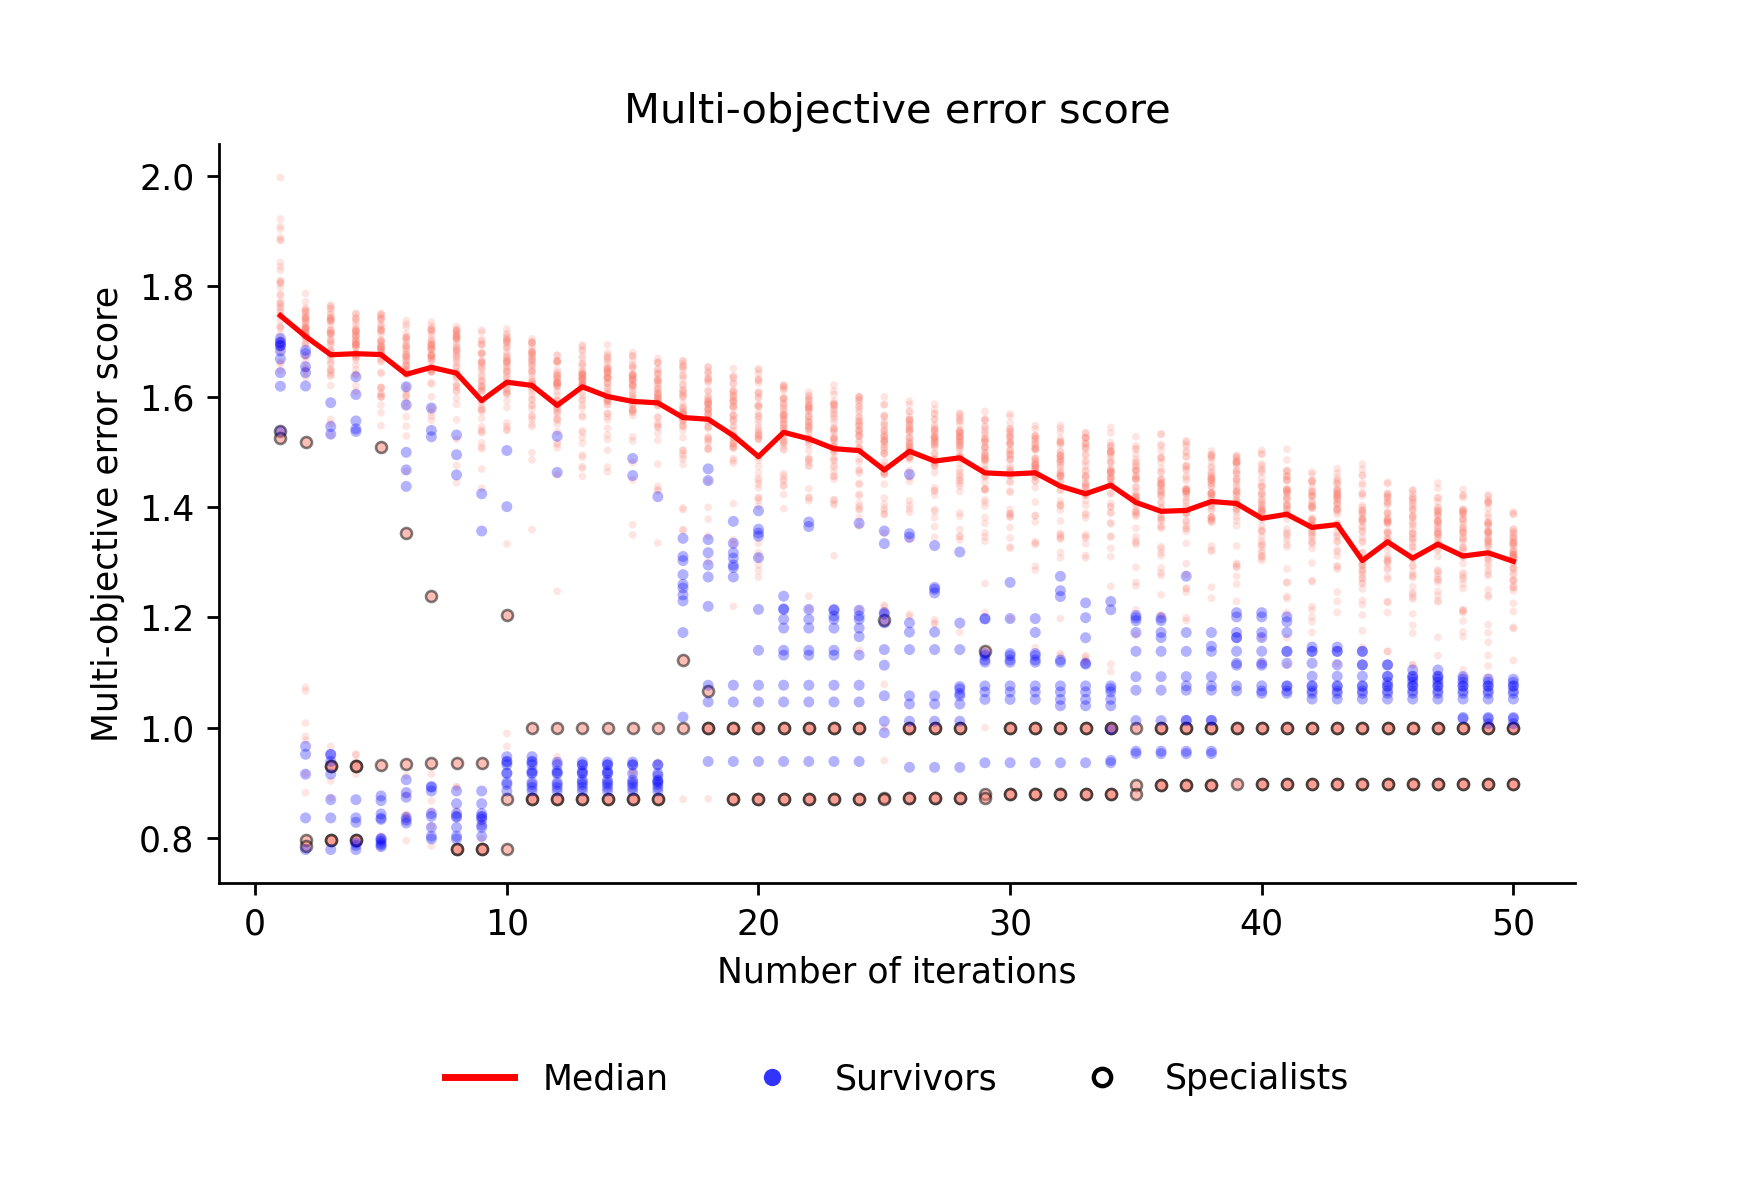

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


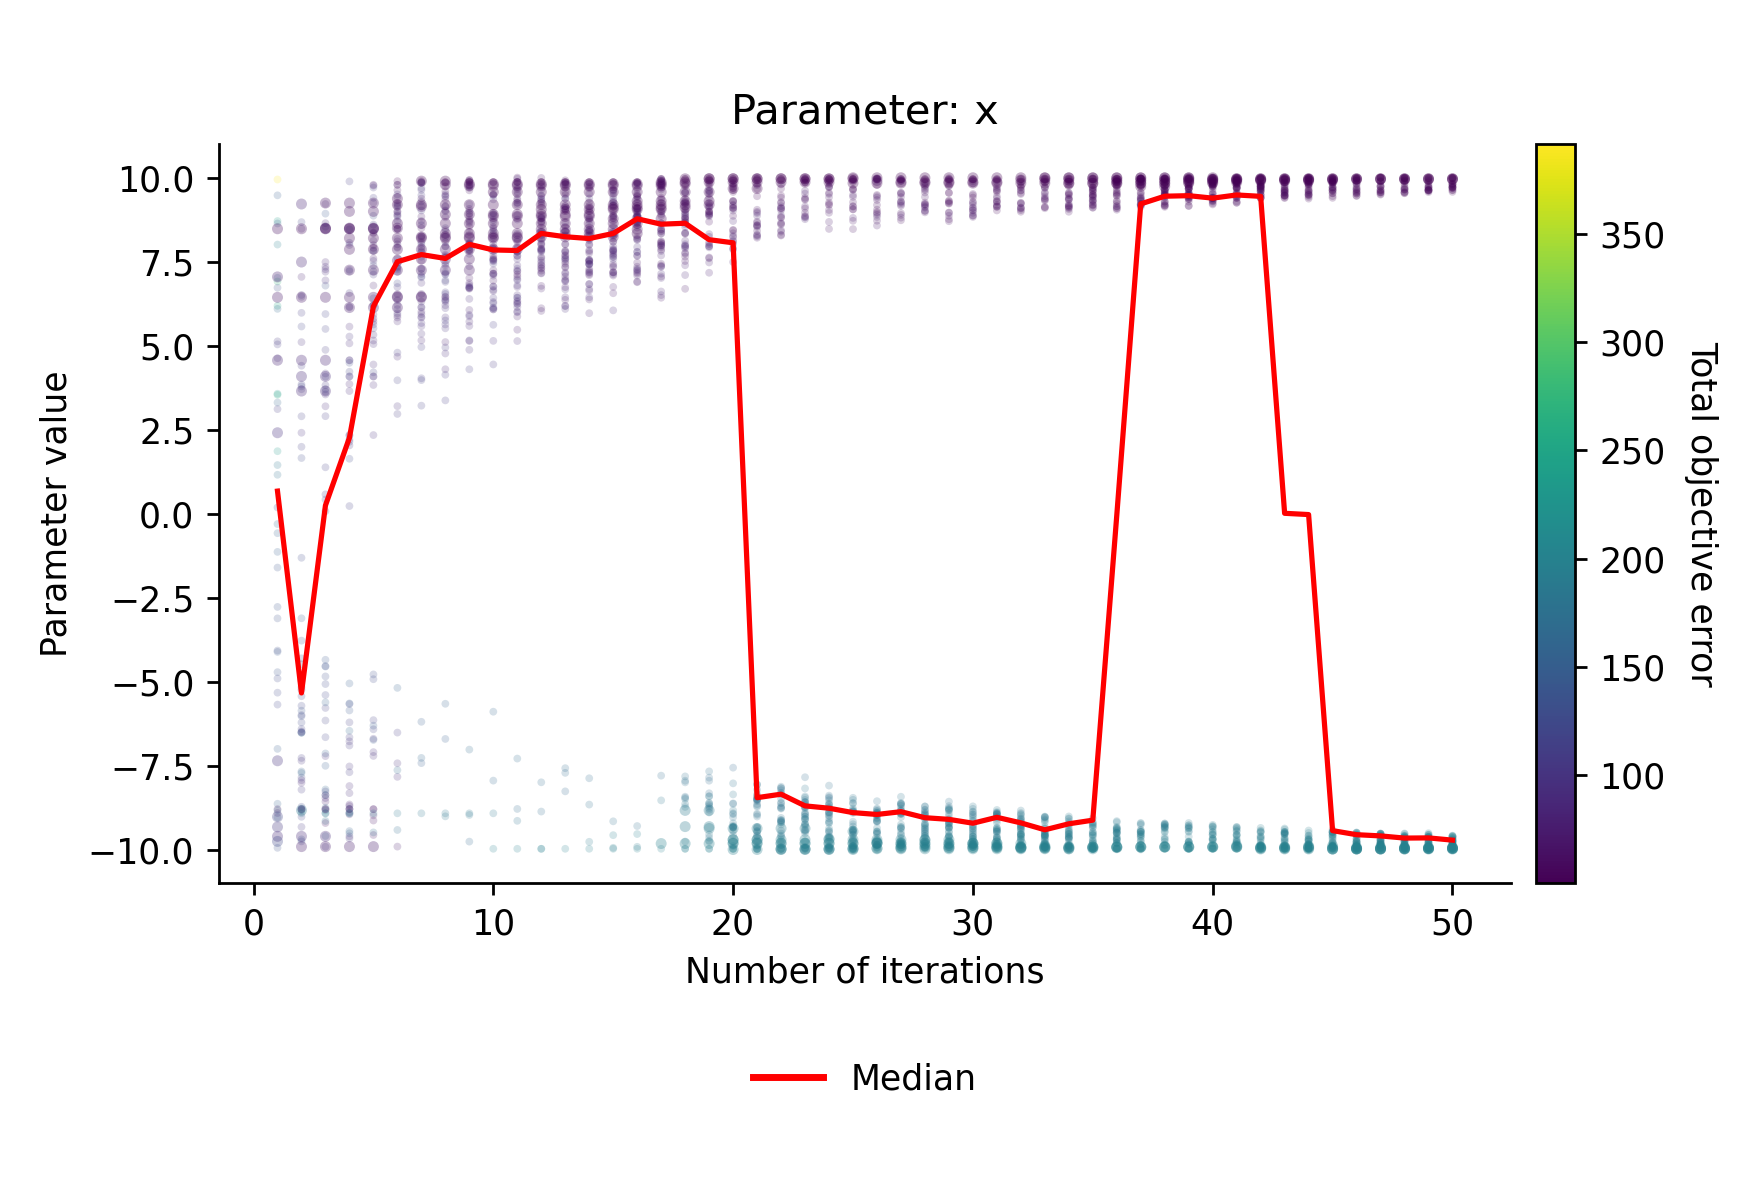

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


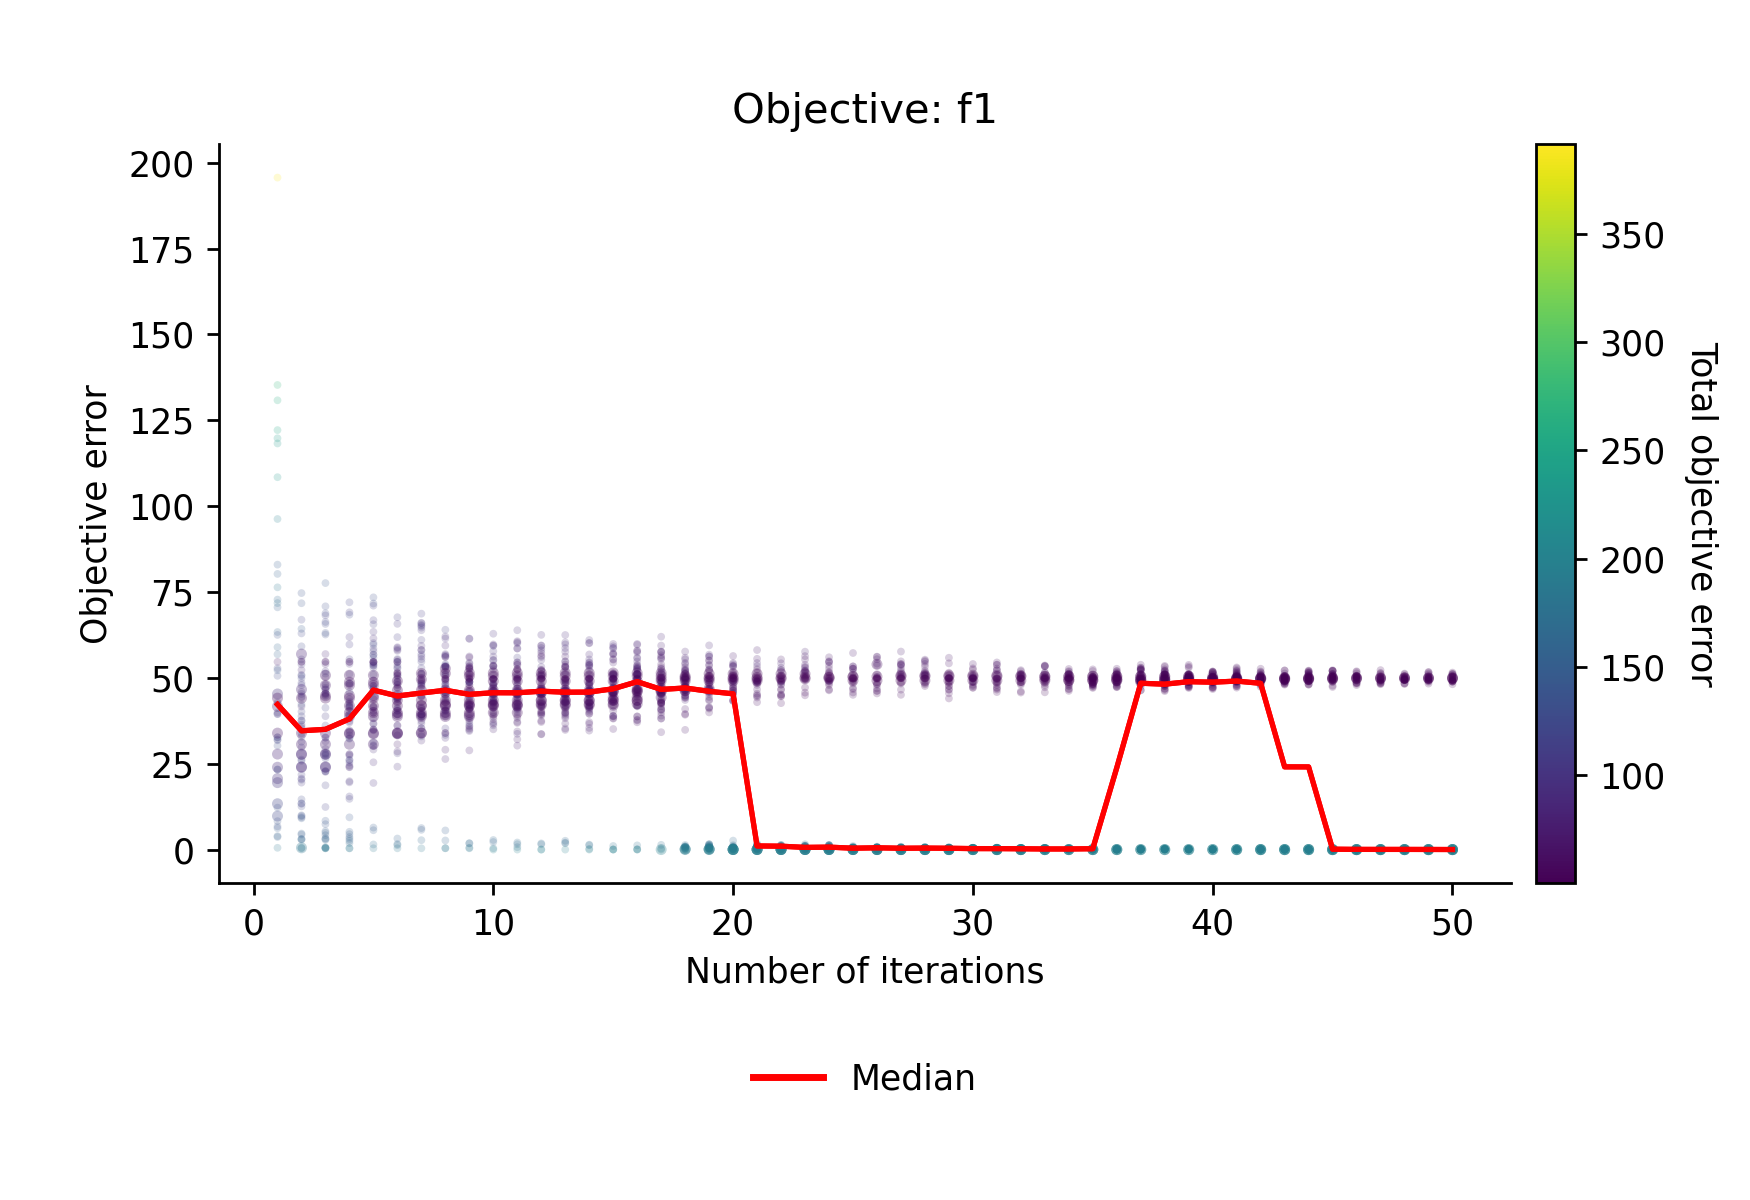

<IPython.core.display.Javascript object>


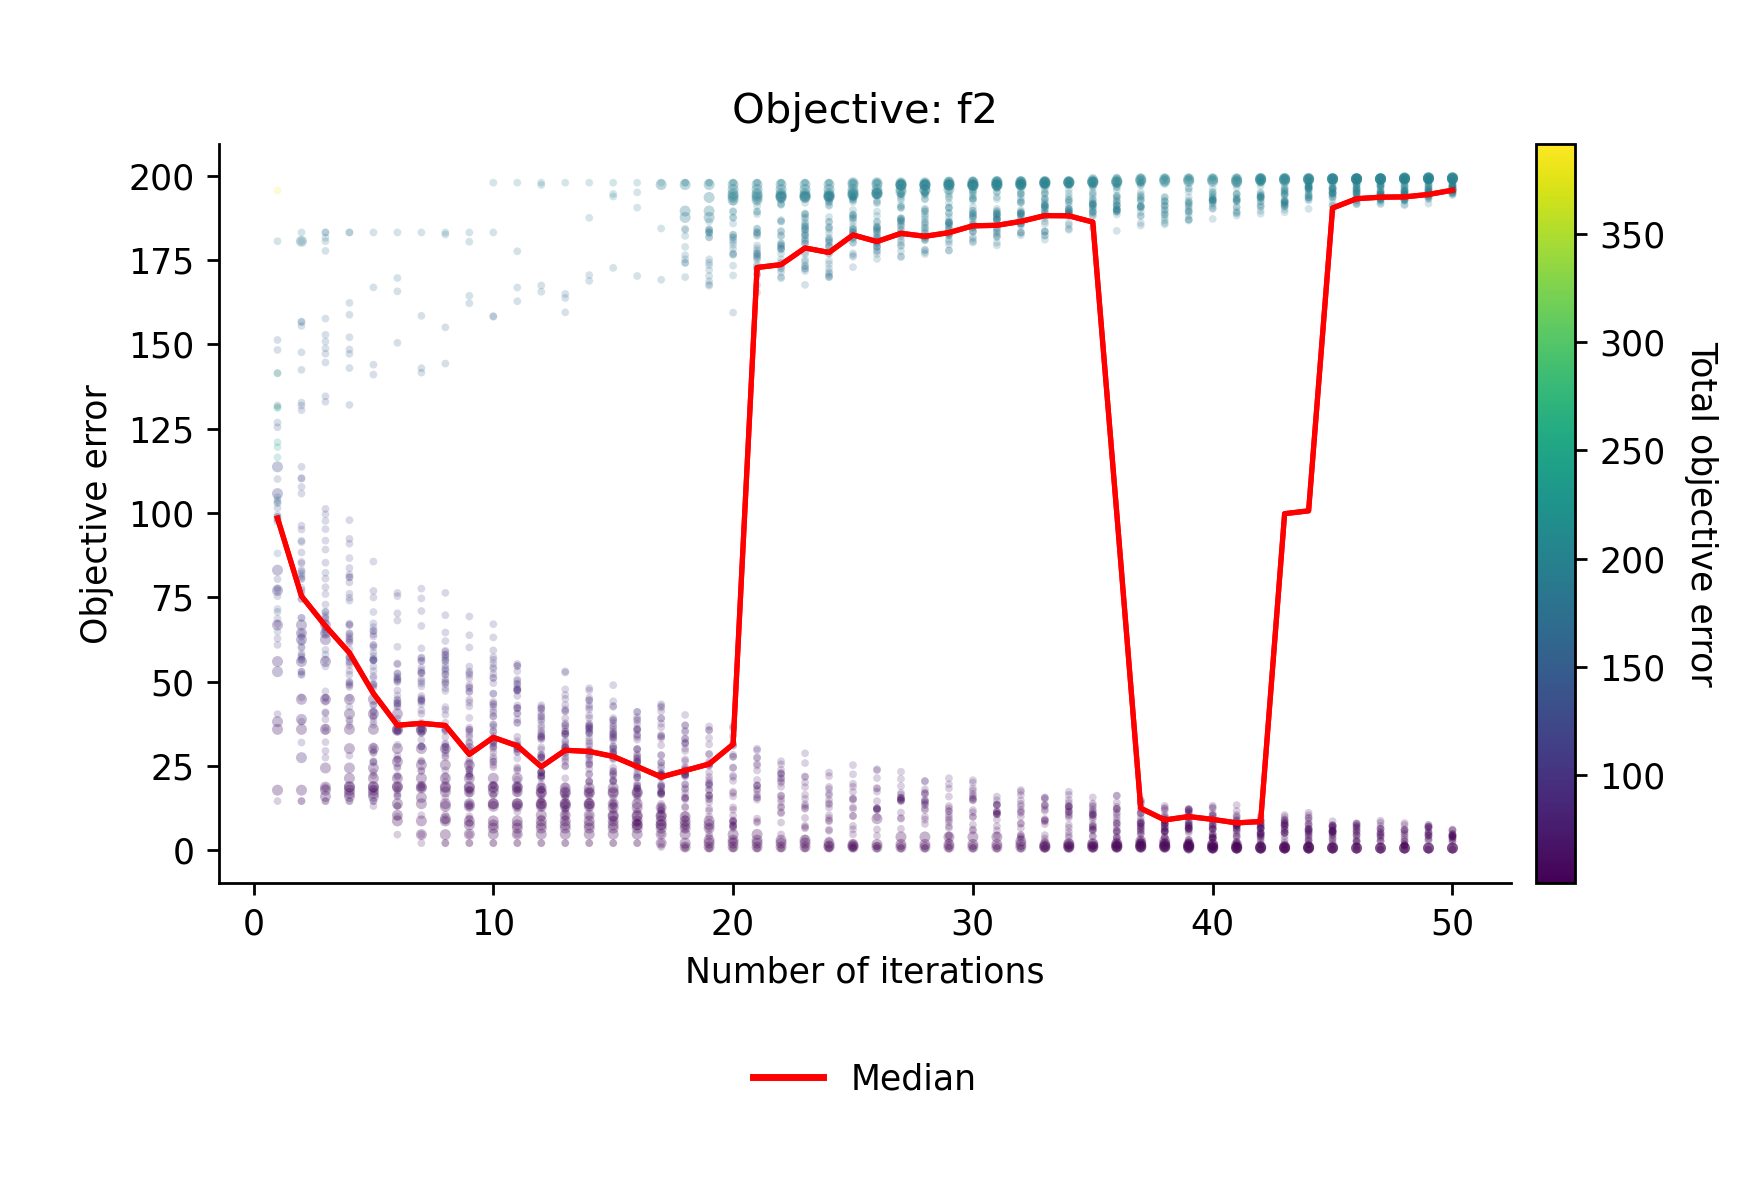

In [58]:
param_gen.storage.plot(['parameters', 'objectives'], energy_scale='linear', energy_color='absolute')

In [29]:
0.95**50

0.07694497527671315